In [20]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from going_modular import data_setup, engine
from torch.utils.tensorboard import SummaryWriter

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [22]:
from pathlib import Path

import requests

data_path = Path("./alphanumber/")
image_path = data_path
train_dir = image_path / "train"
test_dir = image_path / "test"
validate = image_path / "validation"





BATCH_SIZE=32
LEARNING_RATE=0.001
EPOCH=10

In [23]:
train_dir

PosixPath('alphanumber/train')

In [24]:
test_dir

PosixPath('alphanumber/test')

In [25]:
normalize = transforms.Normalize(mean=[0.5],
                                 std=[0.5])


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # FORCE 1 channel
    transforms.Resize((24, 24)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
]) 

In [26]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transform, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0xea3b777ba810>,
 ['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  'lower_a',
  'lower_b',
  'lower_c',
  'lower_d',
  'lower_e',
  'lower_f',
  'lower_g',
  'lower_h',
  'lower_i',
  'lower_j',
  'lower_k',
  'lower_l',
  'lower_m',
  'lower_n',
  'lower_o',
  'lower_p',
  'lower_q',
  'lower_r',
  'lower_s',
  'lower_t',
  'lower_u',
  'lower_v',
  'lower_w',
  'lower_x',
  'lower_y',
  'lower_z',
  'upper_A',
  'upper_B',
  'upper_C',
  'upper_D',
  'upper_E',
  'upper_F',
  'upper_G',
  'upper_H',
  'upper_I',
  'upper_J',
  'upper_K',
  'upper_L',
  'upper_M',
  'upper_N',
  'upper_O',
  'upper_P',
  'upper_Q',
  'upper_R',
  'upper_S',
  'upper_T',
  'upper_U',
  'upper_V',
  'upper_W',
  'upper_X',
  'upper_Y',
  'upper_Z'])

In [27]:
print(len(train_dataloader))
print(len(test_dataloader))

2139
611


In [28]:
import torch
from torch import nn


class HandwrittenCNN(nn.Module):
    def __init__(self, input_channels: int = 1, num_classes: int = 62):
        super().__init__()

        # -------- Feature extractor --------
        self.features = nn.Sequential(
            # Block 1: 1 → 32
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 24x24 → 12x12

            # Block 2: 32 → 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 12x12 → 6x6

            # Block 3: 64 → 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # -------- Classifier --------
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x: torch.Tensor):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [29]:
import torch

from going_modular import model_builder
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate an instance of the model from the "model_builder.py" script
model = HandwrittenCNN().to(device)



In [30]:
from torchinfo import summary

summary(model, 
        input_size=(1, 1, 24, 24), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
HandwrittenCNN (HandwrittenCNN)          [1, 1, 24, 24]       [1, 62]              --                   True
├─Sequential (features)                  [1, 1, 24, 24]       [1, 128, 6, 6]       --                   True
│    └─Conv2d (0)                        [1, 1, 24, 24]       [1, 32, 24, 24]      320                  True
│    └─BatchNorm2d (1)                   [1, 32, 24, 24]      [1, 32, 24, 24]      64                   True
│    └─ReLU (2)                          [1, 32, 24, 24]      [1, 32, 24, 24]      --                   --
│    └─MaxPool2d (3)                     [1, 32, 24, 24]      [1, 32, 12, 12]      --                   --
│    └─Conv2d (4)                        [1, 32, 12, 12]      [1, 64, 12, 12]      18,496               True
│    └─BatchNorm2d (5)                   [1, 64, 12, 12]      [1, 64, 12, 12]      128                  True
│    └─ReLU (6)   

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [32]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter()

In [33]:
X, y = next(iter(train_dataloader))
print(X.shape)

torch.Size([32, 1, 24, 24])


In [34]:
from typing import Dict, List
from tqdm.auto import tqdm
from going_modular.engine import train_step, test_step, train

In [35]:
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=EPOCH,
                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1522 | train_acc: 0.6536 | test_loss: 0.5049 | test_acc: 0.8217
Epoch: 2 | train_loss: 0.6830 | train_acc: 0.7754 | test_loss: 0.4080 | test_acc: 0.8543
Epoch: 3 | train_loss: 0.5723 | train_acc: 0.8061 | test_loss: 0.3831 | test_acc: 0.8612
Epoch: 4 | train_loss: 0.5013 | train_acc: 0.8271 | test_loss: 0.3504 | test_acc: 0.8721
Epoch: 5 | train_loss: 0.4520 | train_acc: 0.8406 | test_loss: 0.3438 | test_acc: 0.8727
Epoch: 6 | train_loss: 0.4091 | train_acc: 0.8537 | test_loss: 0.3291 | test_acc: 0.8775
Epoch: 7 | train_loss: 0.3776 | train_acc: 0.8637 | test_loss: 0.3202 | test_acc: 0.8833
Epoch: 8 | train_loss: 0.3500 | train_acc: 0.8714 | test_loss: 0.3219 | test_acc: 0.8798
Epoch: 9 | train_loss: 0.3246 | train_acc: 0.8784 | test_loss: 0.3142 | test_acc: 0.8854
Epoch: 10 | train_loss: 0.3049 | train_acc: 0.8857 | test_loss: 0.3141 | test_acc: 0.8875


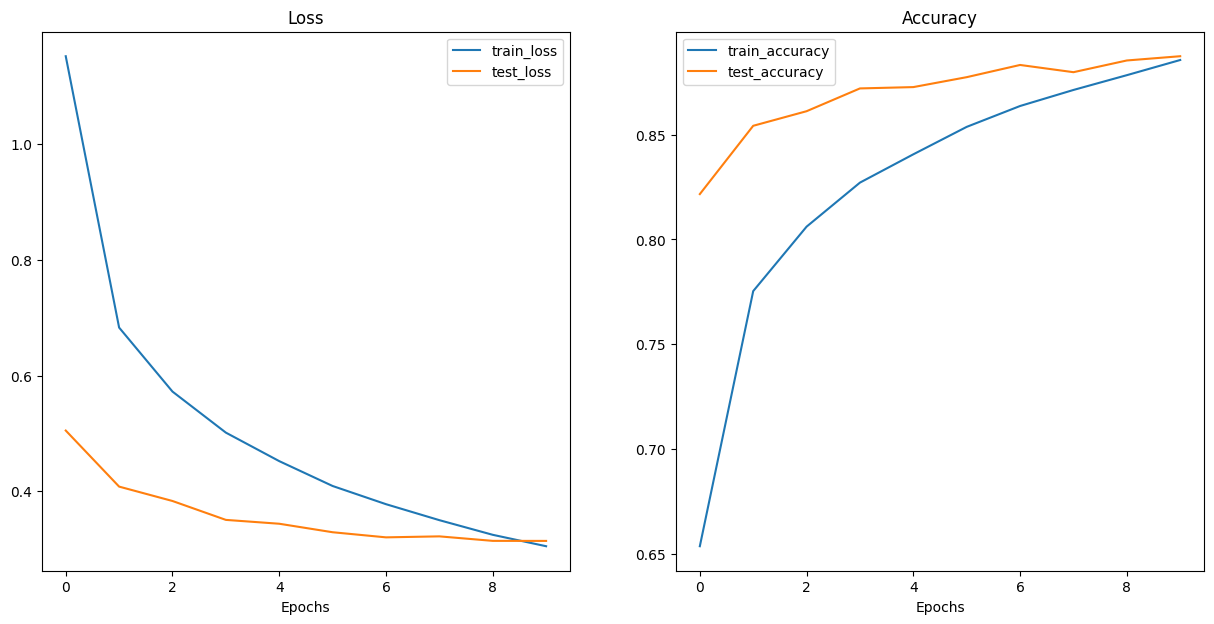

In [36]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)


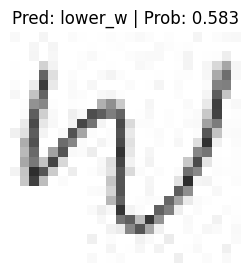

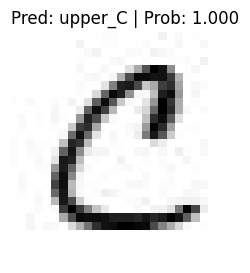

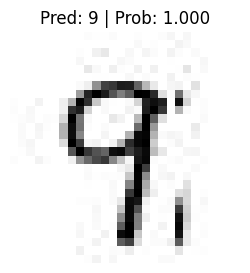

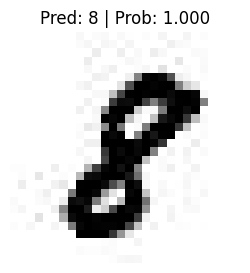

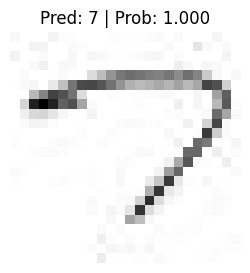

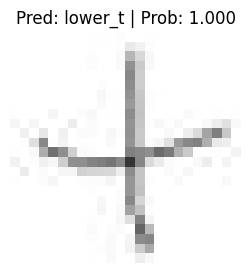

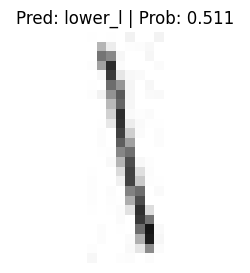

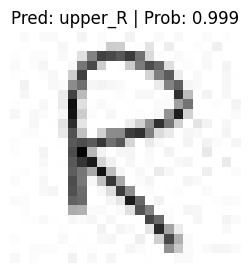

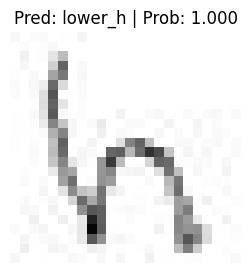

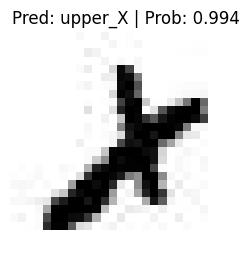

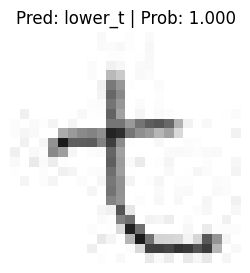

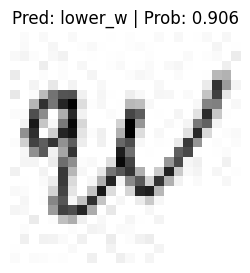

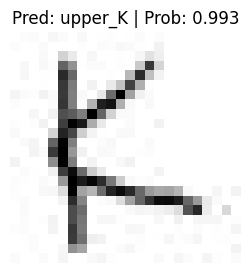

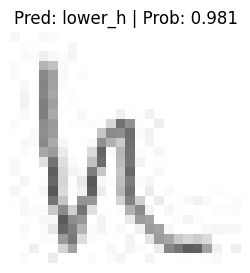

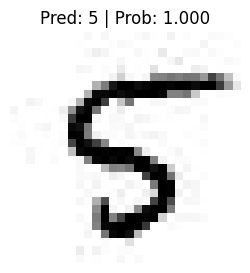

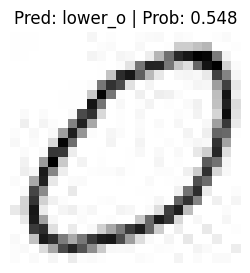

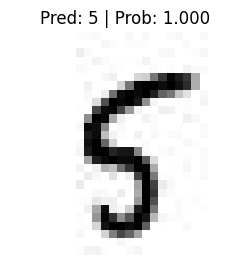

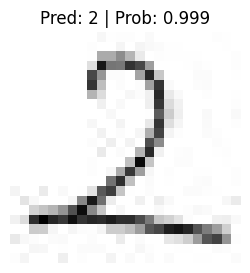

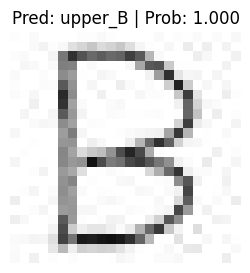

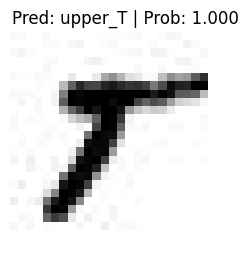

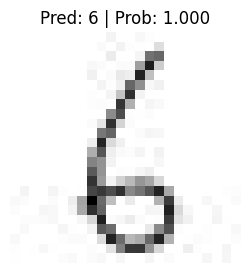

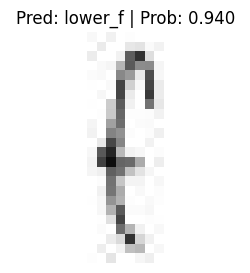

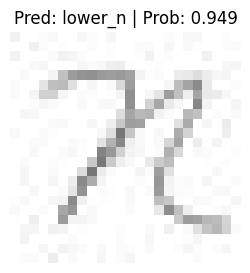

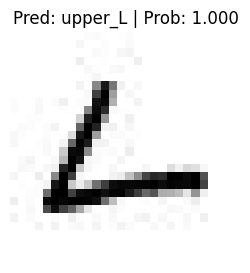

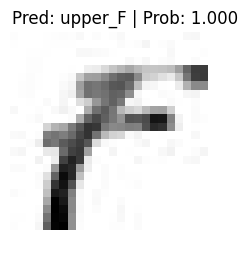

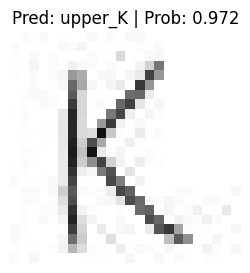

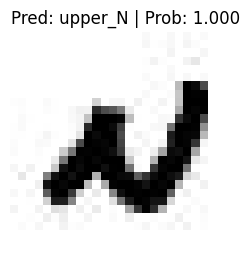

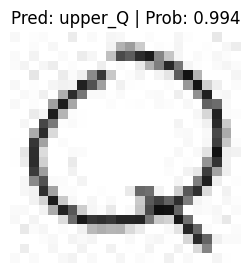

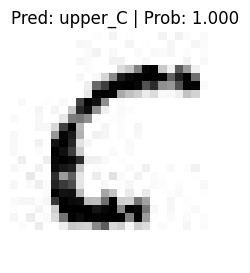

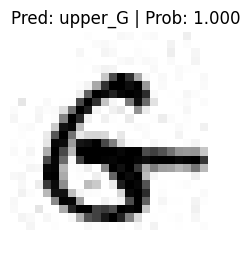

In [37]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 30
validate_image_path_list = list(Path(validate).glob("*/*.jpg")) # get list all image paths from test data 
validate_image_path_sample = random.sample(population=validate_image_path_list, # go through all of the validate image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images


from going_modular.predictions import pred_and_plot_image_GRAY

for image_path in validate_image_path_sample:
    pred_and_plot_image_GRAY(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(24, 24))